In [2]:
# !pip install swifter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import pickle
import random
import sqlite3
import itertools
import os
import pandas as pd
from collections import defaultdict

np.set_printoptions(precision=3)

In [4]:
class Agent:
    def __init__(self):
        pass

    def actRules(self, state):
        return 1
    
    def actNaively(self):
        return 4


In [5]:
#KEY PARAMETERS

lambda_value = 0
table_name = f"gs_results_td_lambda_{lambda_value}".replace(".", "")
directory = "e-greedy/agents" #dir to create
gs_db_name = 'e-greedy/grid_search_greedy_r900.db'

### RADIUS SET TO 900

In [6]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        # self.radius = np.random.randint(600,1201)
        self.radius = 900
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity
    
    def step(self, action):
        return self.transition(action)

In [7]:
new_car = Car()
env = Track(new_car)

agent = Agent()

In [8]:
#Sanity check..

state = env.reset()    
done = False
G = 0
while not done:
    action = agent.actNaively()
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    # state = deepcopy(next_state)
    state = next_state
    G += reward

print("G: %d" % G)

G: -55042


## TDLambda Agent

Discretizing States:

Both the current state and the next_state are discretized using the _discretize_state method. This helps in managing the Q-values in a table format for states that are continuous or too granular.
Initialization of Q-values and Eligibility Traces:

If the current state or next_state is not in the Q-table (Q), it's added with an initial Q-value of zero for all actions.
Similarly, if the current state is not in the eligibility traces table (E), it's added with an initial eligibility trace of zero for all actions.
Temporal Difference (TD) Error Calculation:

The agent calculates the best action for the next_state based on the current Q-values.
The TD error is then computed. It's the difference between the expected Q-value (based on the received reward and the estimated future reward for next_state) and the current Q-value for the taken action at state.
Eligibility Trace Update:

The eligibility trace for the current state-action pair (state, action) is incremented by 1.
This helps in assigning "credit" or "blame" for this state-action pair for any future reward or punishment. SARSA(λ) updates not just the current state-action pair but also the recent ones based on their eligibility traces.
Ensure All States in Q have an Eligibility Trace:

The agent makes sure that for all states in the Q-table, there's a corresponding entry in the eligibility traces table. If not, it adds them with a value of zero.
Update Q-values Using TD Error and Eligibility Traces:

The Q-values for all state-action pairs are updated based on the TD error and their respective eligibility traces. The greater the eligibility trace for a state-action pair, the more it gets updated.
This is the heart of the SARSA(λ) algorithm, allowing the Q-value updates to be spread out not just to the current state-action pair but also to the previous ones based on their eligibility.
Decay All Eligibility Traces:

After updating the Q-values, the eligibility traces for all state-action pairs are decayed by a factor of gamma * td_lambda. This ensures that the traces for older state-action pairs decrease over time, giving more importance to recent state-action pairs for future Q-value updates.
In essence, the update method blends the strengths of both SARSA and eligibility traces, providing a more sophisticated update mechanism that takes into account both immediate and more distant state-action pairs when adjusting Q-values.

In [9]:
class TDLambdaAgent:
    def __init__(self, epsilon=0.1, epsilon_decay=0.995, alpha=0.1,
                  gamma=0.99, td_lambda=lambda_value, n_actions=5,
                    no_change_after_lap=150, state_space_discretization=100):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))
        self.E = defaultdict(lambda: np.zeros(self.n_actions))  # Eligibility traces
        self.n_actions = n_actions
        self.state_space_discretization = state_space_discretization
        self.epsilon_decay = epsilon_decay
        self.no_change_after_lap = no_change_after_lap
        self.td_lambda = td_lambda
        
    def _discretize_state(self, state):
        tyre, condition, weather, radius, laps_cleared = state
        condition = int(condition * self.state_space_discretization)
        
        # Discretizing the radius as well by rounding to nearest hundred
        radius = round(radius, -2)
        return (tyre, condition, weather, radius, laps_cleared)
    
    def act(self, state):
        state = self._discretize_state(state)
        _, _, _, _, laps_cleared = state
        
        if np.random.rand() < self.epsilon:
            if laps_cleared >= self.no_change_after_lap:
                return 4  # Don't change tires
            return np.random.choice(self.n_actions)
        else:
            action = np.argmax(self.Q.get(state, np.zeros(self.n_actions)))
            if laps_cleared >= self.no_change_after_lap and action < 4:
                return 4  # Don't change tires
            return action
        
    def update(self, state, action, reward, next_state):
        state = self._discretize_state(state)
        next_state = self._discretize_state(next_state)
        
        best_next_action = np.argmax(self.Q[next_state])
        td_error = reward + self.gamma * self.Q[next_state][best_next_action] - self.Q[state][action]
        
        # Increment the eligibility trace for the current state-action pair
        self.E[state][action] += 1  
        
        # Update Q-values for all state-action pairs using TD error and the eligibility traces
        for s, actions in self.Q.items():
            for a in range(self.n_actions):
                self.Q[s][a] += self.alpha * td_error * self.E[s][a]
                
                # Decay the eligibility trace for the state-action pair
                self.E[s][a] *= self.gamma * self.td_lambda

# Training the agent
agent = TDLambdaAgent()

num_episodes = 10
eval_episodes = 5

episode_rewards = []
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        # state = deepcopy(next_state)
        state = next_state
        episode_reward += reward
    episode_rewards.append(episode_reward)
    agent.epsilon *= agent.epsilon_decay
    
# Evaluating the agent
total_rewards = []
for _ in tqdm(range(eval_episodes)):
    state = env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.step(action)
        # state = deepcopy(next_state)
        state = next_state
        episode_reward += reward
    total_rewards.append(episode_reward)

print(f"Average reward over {eval_episodes} episodes: {np.mean(total_rewards)}")


 30%|███       | 3/10 [00:38<01:29, 12.73s/it]


KeyboardInterrupt: 

In [ ]:
num_episodes = 5
eval_episodes = 1

# Grid Search
"""
param_grid: dict
    A dictionary containing hyperparameters and their possible values to be explored during grid search. Each key represents a hyperparameter, and its corresponding value is a list of values that will be tested for that hyperparameter.

    Parameters:
    - epsilon: list of floats
        The initial exploration rate for the epsilon-greedy policy. Values represent the probability at which the agent will explore, i.e., take random actions. Higher values mean more exploration and less exploitation.

    - epsilon_decay: list of floats
        The rate at which epsilon will be reduced after each episode. Values are in the range (0, 1) with values closer to 1 meaning a slower decay of epsilon over time.

    - alpha: list of floats
        The learning rate for the Q-learning algorithm. Determines to what extent newly acquired information overrides old information. A value of 0 would make the agent not learn anything, while a value of 1 would make the agent consider only the most recent information.

    - gamma: list of floats
        The discount factor for the Q-learning algorithm. Represents the agent's consideration for future rewards. A value of 0 makes the agent short-sighted by only considering current rewards, while a value close to 1 will make it aim for a long-term high reward.

    - no_change_after_lap: list of integers
        Specifies the lap number after which the agent will not change tires. If the current lap exceeds this number, actions to change tires will not be taken.
"""
param_grid = {
    'epsilon': [0.0, 0.025, 0.05, 0.1, 0.2],
    'epsilon_decay': [0.990, 0.995, 0.999],
    'alpha': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0],
    'gamma': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0],
    'no_change_after_lap': [x for x in range(100, 161, 5)]
}

In [ ]:
def setup_database():
    conn = sqlite3.connect(gs_db_name)
    c = conn.cursor()
    c.execute(f'''CREATE TABLE IF NOT EXISTS {table_name}
                 (epsilon real, epsilon_decay real, alpha real, gamma real, no_change_after_lap integer, 
                  avg_last_50 real, min_last_50 real, max_last_50 real, 
                  eval_avg real, overall_avg real)''')
    conn.commit()
    conn.close()

setup_database()

In [10]:
if not os.path.exists(directory):
    os.makedirs(directory)

if not os.path.exists('e-greedy/hpt_plots'):
    os.makedirs('e-greedy/hpt_plots')

def parameter_combinations(param_grid):
    """
    Generate random combinations of parameters from the given parameter grid.
    
    Args:
    - param_grid (dict): Dictionary containing hyperparameters and their possible values.

    Yields:
    - dict: Random combination of hyperparameters.
    """
    # Connect to the SQLite database and fetch existing combinations
    conn = sqlite3.connect(gs_db_name)
    c = conn.cursor()

    # Check if the table exists. If not, create an empty DataFrame.
    c.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';")
    if c.fetchone():
        existing_combinations_df = pd.read_sql_query(f"SELECT epsilon, epsilon_decay, alpha, gamma, no_change_after_lap FROM {table_name}", conn)
    else:
        existing_combinations_df = pd.DataFrame()

    conn.close()

    # Generate and check combinations
    keys, values = zip(*param_grid.items())
    print(len(keys))
    all_combinations = list(itertools.product(*values))
    random.shuffle(all_combinations)

    for combination in all_combinations:
        param_dict = dict(zip(keys, combination))

        # Check if this combination is already in the database
        conditions = np.logical_and.reduce([existing_combinations_df[k] == v for k, v in param_dict.items()])
        if not existing_combinations_df[conditions].empty:
            print('SKIPPING')
            continue  # Skip this combination if it's already in the database

        yield param_dict

# 1. Plot Episode Rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.title('Episode Rewards Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

# 2. Plot Average Episode Rewards
def plot_avg_rewards(rewards, window=5):
    averages = [np.mean(rewards[max(0, i-window+1):i+1]) for i in range(len(rewards))]
    plt.plot(averages)
    plt.title(f'Average Episode Rewards Over Last {window} Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.show()

# 3. Implement Grid Search
def grid_search(param_grid, num_episodes, eval_episodes):
    conn = sqlite3.connect(gs_db_name)
    c = conn.cursor()

    total_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"Total combinations: {total_combinations}")
    count = 0

    for params in tqdm(parameter_combinations(param_grid)):
        count += 1
        print(f"\nRunning combination {count}/{total_combinations} with parameters: {params}")

        agent = TDLambdaAgent(epsilon=params['epsilon'], epsilon_decay=params['epsilon_decay'], alpha=params['alpha'], gamma=params['gamma'], no_change_after_lap=params['no_change_after_lap'])
        
        # Training phase
        training_rewards = []  # List to store rewards from each episode
        for episode in range(num_episodes):
            if episode % 100 == 0:  # Print update every 100 episodes
                print(f"    Training Episode {episode}/{num_episodes}")
            state = env.reset()
            done = False
            episode_reward = 0 
            while not done:
                action = agent.act(state)
                reward, next_state, done, _ = env.step(action)
                episode_reward += reward
                agent.update(state, action, reward, next_state)
                # state = deepcopy(next_state)
                state = next_state
            training_rewards.append(episode_reward)  # Add the total reward for this episode to the list


        # Evaluation phase
        eval_rewards = []
        for episode in range(eval_episodes):
            if episode % 5 == 0:  # Print update every 100 episodes
                print(f"    Evaluation Episode {episode}/{eval_episodes}")
            state = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = agent.act(state)
                reward, next_state, done, _ = env.step(action)
                episode_reward += reward
                # state = deepcopy(next_state)
                state = next_state
            eval_rewards.append(episode_reward)

        # Compute metrics based on training rewards
        avg_last_50 = np.mean(training_rewards[-50:])
        min_last_50 = np.min(training_rewards[-50:])
        max_last_50 = np.max(training_rewards[-50:])
        eval_avg = np.mean(eval_rewards)
        

        # Print evaluation metrics
        print(f"    Average Reward over last 50 episodes: {avg_last_50:.2f}")
        print(f"    Min Reward over last 50 episodes: {min_last_50:.2f}")
        print(f"    Max Reward over last 50 episodes: {max_last_50:.2f}")
        print(f"    Evaluation Average Reward: {eval_avg:.2f}")

        # Save metrics to database
        c.execute(f"""INSERT INTO {table_name} (epsilon, epsilon_decay, alpha, gamma, no_change_after_lap, 
                                               avg_last_50, min_last_50, max_last_50, 
                                               eval_avg, overall_avg) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""", 
                  (params['epsilon'], params['epsilon_decay'], params['alpha'], params['gamma'], 
                   params['no_change_after_lap'], avg_last_50, min_last_50, max_last_50, 
                   eval_avg, np.mean(training_rewards)))

        conn.commit()
        
    conn.close()

grid_search(param_grid, num_episodes, eval_episodes)

In [11]:
conn = sqlite3.connect(gs_db_name)
df = pd.read_sql_query(f"SELECT COUNT(*) from {table_name}", conn)
print(df.shape)
print(df)
conn.close()

(1, 1)
   COUNT(*)
0       647


In [12]:
# !pip install nbformat --upgrade

Index(['epsilon', 'epsilon_decay', 'alpha', 'gamma', 'no_change_after_lap',
       'avg_last_50', 'min_last_50', 'max_last_50', 'eval_avg', 'overall_avg'],
      dtype='object')


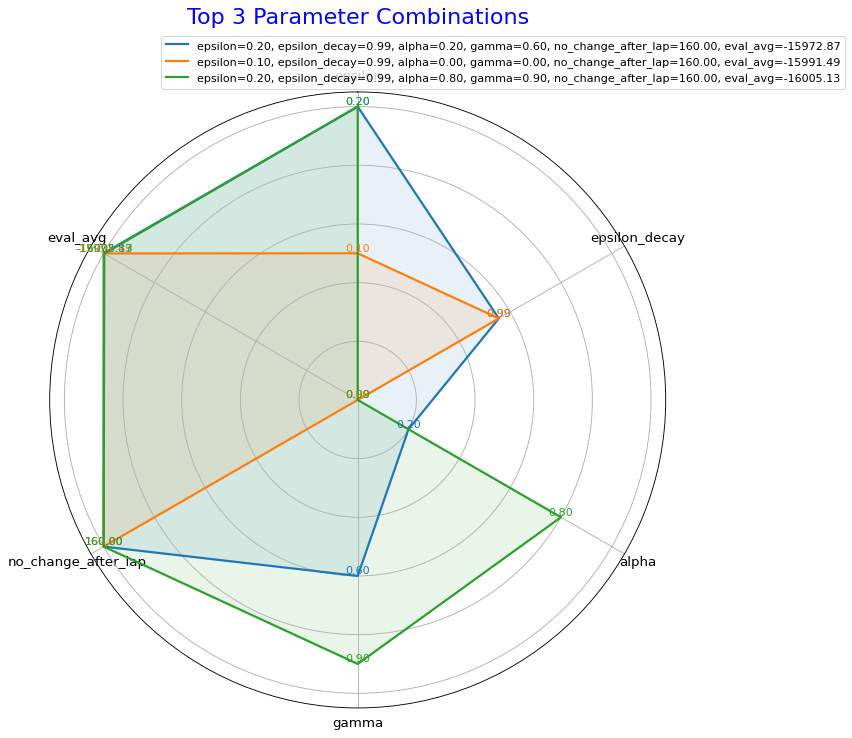

     epsilon  epsilon_decay  alpha  gamma  no_change_after_lap   avg_last_50  \
315      0.2          0.995    0.2    0.6                  160 -16054.310293   
28       0.1          0.995    0.0    0.0                  160 -16098.246422   
604      0.2          0.990    0.8    0.9                  160 -16055.503381   

      min_last_50   max_last_50      eval_avg   overall_avg  
315 -16144.504846 -16002.402039 -15972.868982 -16054.310293  
28  -16180.435035 -16016.128748 -15991.486602 -16098.246422  
604 -16141.997887 -15988.538458 -16005.126126 -16055.503381  


In [13]:
def radar_plot_top_combinations(db_name=gs_db_name, top_n=5):
    # Connect to the database and fetch data
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(f"SELECT * from {table_name}", conn)
    conn.close()
    
    print(df.columns)
    # Columns you want to include in the radar plot (i.e., your hyperparameters)
    hyperparameter_columns = ['epsilon', 'epsilon_decay', 'alpha', 'gamma', 'no_change_after_lap', 'eval_avg']

    # Normalize the hyperparameters based on all rows
    normalized_df = (df[hyperparameter_columns] - df[hyperparameter_columns].min()) / (df[hyperparameter_columns].max() - df[hyperparameter_columns].min())
    
    # Sort by eval_reward (if it exists) and take top N
    sort_column = 'eval_avg' if 'eval_avg' in df.columns else hyperparameter_columns[0]
    top_rows_df = df.nlargest(top_n, sort_column)
    top_normalized_df = normalized_df.loc[top_rows_df.index]

    # Radar plot
    from math import pi
    labels = hyperparameter_columns
    num_vars = len(labels)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Adding the first angle at the end to close the circle

    plt.figure(figsize=(10, 10), dpi=80)
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1])  # Removing the last angle for the labels
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])

    for i in range(top_n):
        norm_values = top_normalized_df.iloc[i].values.flatten().tolist()
        norm_values += norm_values[:1]  # Add the first value to the end to close the circle

        true_values_list = top_rows_df.iloc[i][hyperparameter_columns].values.flatten().tolist()

        param_string = ', '.join([f"{col}={val:.2f}" for col, val in zip(labels, true_values_list)])
        line = ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=param_string)
        ax.fill(angles, norm_values, alpha=0.1)

        # Annotate with the true values
        for angle, value, true_value in zip(angles, norm_values, true_values_list):
            ax.annotate(f"{true_value:.2f}", 
                        xy=(angle, value), 
                        color=line[0].get_color(),
                        ha='center', va='bottom')

    plt.title(f'Top {top_n} Parameter Combinations', size=20, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

    print(top_rows_df)

radar_plot_top_combinations(top_n=3)
